In [ ]:
pip install transformers datasets accelerate torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineG

In [ ]:
import pandas as pd
from PIL import Image
from io import BytesIO
import base64
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForImageSegmentation
import time
import matplotlib.pyplot as plt

from huggingface_hub import create_repo
from huggingface_hub import HfApi, upload_folder

In [ ]:
df = pd.read_parquet("hf://datasets/svjack/ZHONGLI_Holding_A_Sign_Images_MASK_DEPTH_RMBG_1024x1024/data/train-00000-of-00001.parquet")
print(df.columns)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Index(['original_image', 'sign_mask', 'robot_depth', 'transparent_image',
       'mask_image'],
      dtype='object')


In [ ]:
def decode_image(entry):
    if isinstance(entry, dict):
        entry = entry.get("bytes", b"")
    if not isinstance(entry, (bytes, bytearray)):
        raise ValueError("Image data is not raw bytes")
    return Image.open(BytesIO(entry)).convert("RGB")

def decode_mask(entry):
    if isinstance(entry, dict):
        entry = entry.get("bytes", b"")
    if not isinstance(entry, (bytes, bytearray)):
        raise ValueError("Mask data is not raw bytes")
    return Image.open(BytesIO(entry)).convert("L")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class RMBGDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = decode_image(self.df.iloc[idx]["original_image"])
        mask = decode_mask(self.df.iloc[idx]["mask_image"])
        return {
            "pixel_values": self.image_transform(image),
            "mask": self.mask_transform(mask),
        }

In [ ]:
class LoRAConv2d(nn.Module):
    def __init__(self, conv: nn.Conv2d, r=4, alpha=1.0):
        super().__init__()
        self.conv = conv
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        self.lora_A = nn.Conv2d(conv.in_channels, r, kernel_size=1, bias=False)
        self.lora_B = nn.Conv2d(r, conv.out_channels, kernel_size=1, bias=False)

        nn.init.kaiming_uniform_(self.lora_A.weight, a=5**0.5)
        nn.init.zeros_(self.lora_B.weight)

        for param in self.conv.parameters():
            param.requires_grad = False

    def forward(self, x):
        a_out = self.lora_A(x)
        b_out = self.lora_B(a_out)

        conv_out = self.conv(x)

        # Resize b_out to match conv_out spatial shape
        if b_out.shape[-2:] != conv_out.shape[-2:]:
            b_out = nn.functional.interpolate(
                b_out,
                size=conv_out.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

        out = conv_out + b_out * self.scaling
        return out


In [ ]:
model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)
model.to(device)

BriaRMBG(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Custom filtering rule
def should_wrap(name):
    return not any(skip in name for skip in [".norm", ".bn", "lora_", ".bias"])

# Wrap selected Conv2d layers with LoRA
layers_to_wrap = []
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) and should_wrap(name):
        layers_to_wrap.append((name, module))

print("Layers to wrap:", layers_to_wrap)

Layers to wrap: [('conv_in', Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), ('stage1.rebnconvin.conv_s1', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv1.conv_s1', Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv2.conv_s1', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv3.conv_s1', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv4.conv_s1', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv5.conv_s1', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv6.conv_s1', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.rebnconv7.conv_s1', Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))), ('stage1.rebnconv6d.conv_s1', Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('stage1.reb

In [ ]:
for name, module in layers_to_wrap:
    print("Wrapping: ", name)
    parts = name.split(".")
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    setattr(parent, parts[-1], LoRAConv2d(module, r=32, alpha=16))

model.to(device)


Wrapping:  conv_in
Wrapping:  stage1.rebnconvin.conv_s1
Wrapping:  stage1.rebnconv1.conv_s1
Wrapping:  stage1.rebnconv2.conv_s1
Wrapping:  stage1.rebnconv3.conv_s1
Wrapping:  stage1.rebnconv4.conv_s1
Wrapping:  stage1.rebnconv5.conv_s1
Wrapping:  stage1.rebnconv6.conv_s1
Wrapping:  stage1.rebnconv7.conv_s1
Wrapping:  stage1.rebnconv6d.conv_s1
Wrapping:  stage1.rebnconv5d.conv_s1
Wrapping:  stage1.rebnconv4d.conv_s1
Wrapping:  stage1.rebnconv3d.conv_s1
Wrapping:  stage1.rebnconv2d.conv_s1
Wrapping:  stage1.rebnconv1d.conv_s1
Wrapping:  stage2.rebnconvin.conv_s1
Wrapping:  stage2.rebnconv1.conv_s1
Wrapping:  stage2.rebnconv2.conv_s1
Wrapping:  stage2.rebnconv3.conv_s1
Wrapping:  stage2.rebnconv4.conv_s1
Wrapping:  stage2.rebnconv5.conv_s1
Wrapping:  stage2.rebnconv6.conv_s1
Wrapping:  stage2.rebnconv5d.conv_s1
Wrapping:  stage2.rebnconv4d.conv_s1
Wrapping:  stage2.rebnconv3d.conv_s1
Wrapping:  stage2.rebnconv2d.conv_s1
Wrapping:  stage2.rebnconv1d.conv_s1
Wrapping:  stage3.rebnconvin.con

BriaRMBG(
  (conv_in): LoRAConv2d(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lora_A): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (lora_B): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): LoRAConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lora_A): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (lora_B): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): LoRAConv2d(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lora_A): Conv2d(64, 32, kernel_size=(

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Trainable:", name, param.shape)

Trainable: conv_in.lora_A.weight torch.Size([32, 3, 1, 1])
Trainable: conv_in.lora_B.weight torch.Size([64, 32, 1, 1])
Trainable: stage1.rebnconvin.conv_s1.lora_A.weight torch.Size([32, 64, 1, 1])
Trainable: stage1.rebnconvin.conv_s1.lora_B.weight torch.Size([64, 32, 1, 1])
Trainable: stage1.rebnconv1.conv_s1.lora_A.weight torch.Size([32, 64, 1, 1])
Trainable: stage1.rebnconv1.conv_s1.lora_B.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv2.conv_s1.lora_A.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv2.conv_s1.lora_B.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv3.conv_s1.lora_A.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv3.conv_s1.lora_B.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv4.conv_s1.lora_A.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv4.conv_s1.lora_B.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv5.conv_s1.lora_A.weight torch.Size([32, 32, 1, 1])
Trainable: stage1.rebnconv5.conv

In [ ]:
def print_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable} / {total} ({100 * trainable / total:.2f}%)")

print_trainable_parameters(model)

Trainable params: 1154336 / 45201126 (2.55%)


In [ ]:
lora_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(lora_params, lr=1e-4)
loss_fn = nn.BCELoss()

In [ ]:
dataset = RMBGDataset(df)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
num_epochs = 30
model.train()

BriaRMBG(
  (conv_in): LoRAConv2d(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lora_A): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (lora_B): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): LoRAConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lora_A): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (lora_B): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): LoRAConv2d(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lora_A): Conv2d(64, 32, kernel_size=(

In [ ]:
losses = []
accuracies = []
ious = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_iou = 0.0
    total_batches = 0
    total_time = 0.0

    start_time = time.perf_counter()
    for batch_idx, batch in enumerate(dataloader):
        images = batch["pixel_values"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad()
        preds = model(images)[0][5]

        if preds.shape != masks.shape:
            preds = preds.squeeze(1)

        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

        with torch.no_grad():
            predicted_mask = (preds > 0.5).float()

            correct_pixels += (predicted_mask == masks).sum().item()
            total_pixels += masks.numel()

            intersection = (predicted_mask * masks).sum(dim=(1, 2))
            union = predicted_mask.sum(dim=(1, 2)) + masks.sum(dim=(1, 2)) - intersection + 1e-6
            batch_iou = (intersection / union).mean().item()
            total_iou += batch_iou

    end_time = time.perf_counter()
    total_time = end_time - start_time

    avg_loss = total_loss / total_batches
    accuracy = 100 * correct_pixels / total_pixels
    avg_iou = total_iou / total_batches

    losses.append(avg_loss)
    accuracies.append(accuracy)
    ious.append(avg_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}] __ Loss: {avg_loss:.4f} __ Accuracy: {accuracy:.2f}% __ IoU: {avg_iou:.4f} __ Time: {total_time:.2f} sec")

Epoch [1/30] __ Loss: 0.2320 __ Accuracy: 69.76% __ IoU: 0.6003 __ Time: 52.47 sec
Epoch [2/30] __ Loss: 0.2225 __ Accuracy: 69.62% __ IoU: 0.5972 __ Time: 51.87 sec
Epoch [3/30] __ Loss: 0.1888 __ Accuracy: 69.82% __ IoU: 0.6048 __ Time: 52.24 sec
Epoch [4/30] __ Loss: 0.1672 __ Accuracy: 69.93% __ IoU: 0.6098 __ Time: 51.96 sec
Epoch [5/30] __ Loss: 0.1924 __ Accuracy: 69.91% __ IoU: 0.6069 __ Time: 52.02 sec
Epoch [6/30] __ Loss: 0.1690 __ Accuracy: 69.84% __ IoU: 0.6104 __ Time: 52.08 sec
Epoch [7/30] __ Loss: 0.1572 __ Accuracy: 69.90% __ IoU: 0.6125 __ Time: 51.96 sec
Epoch [8/30] __ Loss: 0.1613 __ Accuracy: 69.72% __ IoU: 0.6152 __ Time: 52.08 sec
Epoch [9/30] __ Loss: 0.1639 __ Accuracy: 69.99% __ IoU: 0.6139 __ Time: 52.03 sec
Epoch [10/30] __ Loss: 0.1473 __ Accuracy: 70.02% __ IoU: 0.6190 __ Time: 51.91 sec
Epoch [11/30] __ Loss: 0.1350 __ Accuracy: 70.07% __ IoU: 0.6192 __ Time: 52.08 sec
Epoch [12/30] __ Loss: 0.1331 __ Accuracy: 69.99% __ IoU: 0.6206 __ Time: 51.97 sec
E

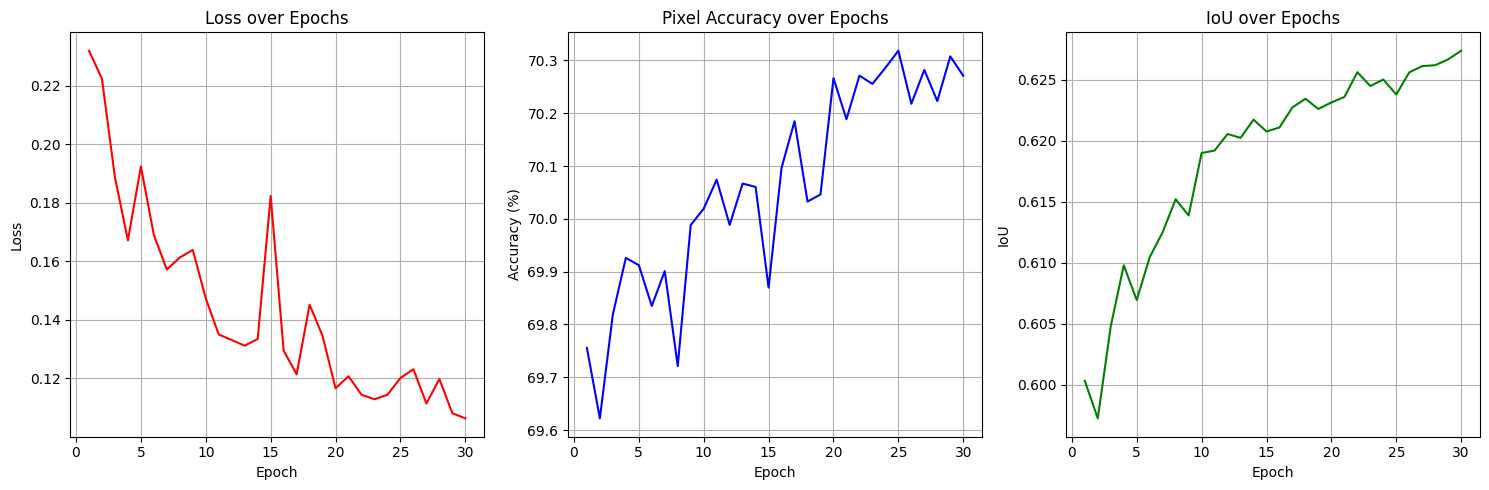

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracies, label='Pixel Accuracy (%)', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Pixel Accuracy over Epochs')
plt.grid(True)

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, ious, label='IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.save_pretrained("rmbg-finetuned")

In [ ]:
create_repo("rmbg-1.4-finetuned", private=False)

RepoUrl('https://huggingface.co/ahmedtarfa/rmbg-1.4-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='ahmedtarfa/rmbg-1.4-finetuned')

In [ ]:
upload_folder(
    folder_path="rmbg-finetuned",
    path_in_repo=".",  # root of the repo
    repo_id="ahmedtarfa/rmbg-1.4-finetuned",
    repo_type="model",
    commit_message="Upload fine-tuned RMBG model"
)

model.safetensors:   0%|          | 0.00/181M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ahmedtarfa/rmbg-1.4-finetuned/commit/9134eda9b05daca48b41c138bd4205dff6f1f416', commit_message='Upload fine-tuned RMBG model', commit_description='', oid='9134eda9b05daca48b41c138bd4205dff6f1f416', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ahmedtarfa/rmbg-1.4-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='ahmedtarfa/rmbg-1.4-finetuned'), pr_revision=None, pr_num=None)